# **Microproyecto 2: Clustering**

Andrés Esteban Monsalve

Sebastián Aguinaga

Daniel Bustamante Mazo

* Importamos las librerías necesarias

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sb
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (25, 12)
plt.style.use('ggplot')

## 1. Preprocesamiento de los datos

In [2]:
# Ruta de los datos
ruta = "https://docs.google.com/spreadsheets/d/1vK2PT3ohHZdO_-60BQwD9Xz1oiW1dXUTAZ85lJ6FRgU/pub?output=csv"
# Abrir el dataframe desde el archivo csv
chi_df = pd.read_csv(ruta, encoding='latin1',header=1)[:-2]

# Visualizar las primeras filas del dataframe
chi_df.head()

,HDI Rank (2017),Country,2010,Unnamed: 3,2011,Unnamed: 5,2012,Unnamed: 7,2013,Unnamed: 9,2014,Unnamed: 11,2015,Unnamed: 13,2016,Unnamed: 15,2017,Unnamed: 17
0,168,Afghanistan,..,..,..,..,..,..,30,..,30,..,30.4,..,28.2,..,28.2,..
1,68,Albania,12.7,..,13.8,..,13.8,..,13.4,..,13.4,..,13.4,..,12.2,..,10,..
2,85,Algeria,..,..,..,..,..,..,..,..,..,..,..,..,..,..,20.1,..
3,147,Angola,38.8,..,..,..,43.6,..,43.6,..,36.6,..,36.6,..,32.3,..,32.3,..
4,47,Argentina,19,..,18.7,..,18.7,..,15.3,..,14.6,..,15.2,..,14,..,13.9,..


In [3]:
# Información del contenido de las columnas del dataframe
chi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   HDI Rank (2017)  195 non-null    object
 1   Country          195 non-null    object
 2   2010             195 non-null    object
 3   Unnamed: 3       195 non-null    object
 4   2011             195 non-null    object
 5   Unnamed: 5       195 non-null    object
 6   2012             195 non-null    object
 7   Unnamed: 7       195 non-null    object
 8   2013             195 non-null    object
 9   Unnamed: 9       195 non-null    object
 10  2014             195 non-null    object
 11  Unnamed: 11      195 non-null    object
 12  2015             195 non-null    object
 13  Unnamed: 13      195 non-null    object
 14  2016             195 non-null    object
 15  Unnamed: 15      195 non-null    object
 16  2017             195 non-null    object
 17  Unnamed: 17      195 non-null    ob

Analizando el dataframe podemos hacer las siguientes observaciones:

* La segunda columna está compuesta por strings(nombre de paises) y no se puede considerar categórica ya que estas etiquetas no se repiten, por lo tanto, no será utilizada hasta el final del proceso dado que estas no son relevantes para aplicar clustering.

* A partir de la cuarta columna, vemos que cada dos columnas se presenta una columna que contiene unicamente valores "..", se pueden apreciar facilmente ya que tienen como nombre de la columna "unnamed". Estas columnas también serán eliminadas.

* En el resto de columnas numéricas diferentes a los dos tipos de columnas anteriormente mencionadas, se puede apreciar que los valores N/A fueron rellenados con el string "..". Esto se debe corregir y asignarles el valor de N/A para poder tomar estas columnas como numéricas y realizar los procedimientos posteriores.

* La información valiosa que encontramos en el dataframe son el índice de desarrollo humano de los paises en el 2017 y el coeficiente de desigualdad humana desde el 2010 hasta el 2017 en cada uno de los paises.

In [4]:
# Eliminar las filas y columnas no deseadas (que no contienen datos)
chi_df.drop(chi_df.columns[[i for i in range(3, 18, 2)]], axis=1, inplace=True)

# Reemplazar los ".." con NaN
chi_df.replace("..", np.nan, inplace=True)

# Eliminar filas con valores nulos para poder hacer matriz de correlacion mas adelante
chi_df = chi_df.dropna()

# Por ultimo realizar una mezcla de los datos
chi_df = chi_df.sample(frac=1).reset_index(drop=True)

# Hacemos una copia del dataframe mientras aún contiene el feature "Country"
chi_df_country = chi_df.copy()

# Eliminar columna con valores que no son numericos
chi_df.drop(chi_df.columns[[1]], axis=1, inplace=True)

# Convertir los datos de string a numericos
for col in chi_df.columns:
  chi_df[col] = pd.to_numeric(chi_df[col])

In [5]:
# Visualizacion de los datos luego de limpieza general
head = chi_df.head()
tail = chi_df.tail()
shape = chi_df.shape

print("Forma de los datos: ", shape, "\n")
print("Principio del dataframe: \n", head, "\n")
print("Final del dataframe: \n",tail)

Forma de los datos:  (121, 9) 

Principio del dataframe: 
    HDI Rank (2017)  2010  2011  2012  2013  2014  2015  2016  2017
0               53   9.3   8.3   8.3   7.6   7.1   6.4   6.5   6.5
1              150  30.0  29.9  29.5  28.7  28.6  29.6  29.0  29.6
2               70  16.6  13.7  14.8  14.0  13.2  12.2  11.5  12.0
3              142  31.7  33.6  33.6  32.7  31.2  29.4  26.3  26.3
4              186  37.7  38.8  38.8  36.8  39.6  39.6  37.9  37.9 

Final del dataframe: 
      HDI Rank (2017)  2010  2011  2012  2013  2014  2015  2016  2017
116               92  14.9  13.7  15.8  11.4  12.8  12.9  13.7  13.7
117               80  13.4  11.1  11.1  11.5  13.0  12.9  10.0   9.9
118               20   7.3   7.2   6.5   7.1   7.6   8.5   7.4   7.8
119              156  29.6  28.4  28.1  26.8  26.7  28.1  23.5  23.5
120              125  18.4  21.8  18.9  18.0  18.0  18.5  18.4  18.4


Ya con los datos limpios y transformados podemos realizar un análisis descriptivo y exploratorio.

<Axes: >

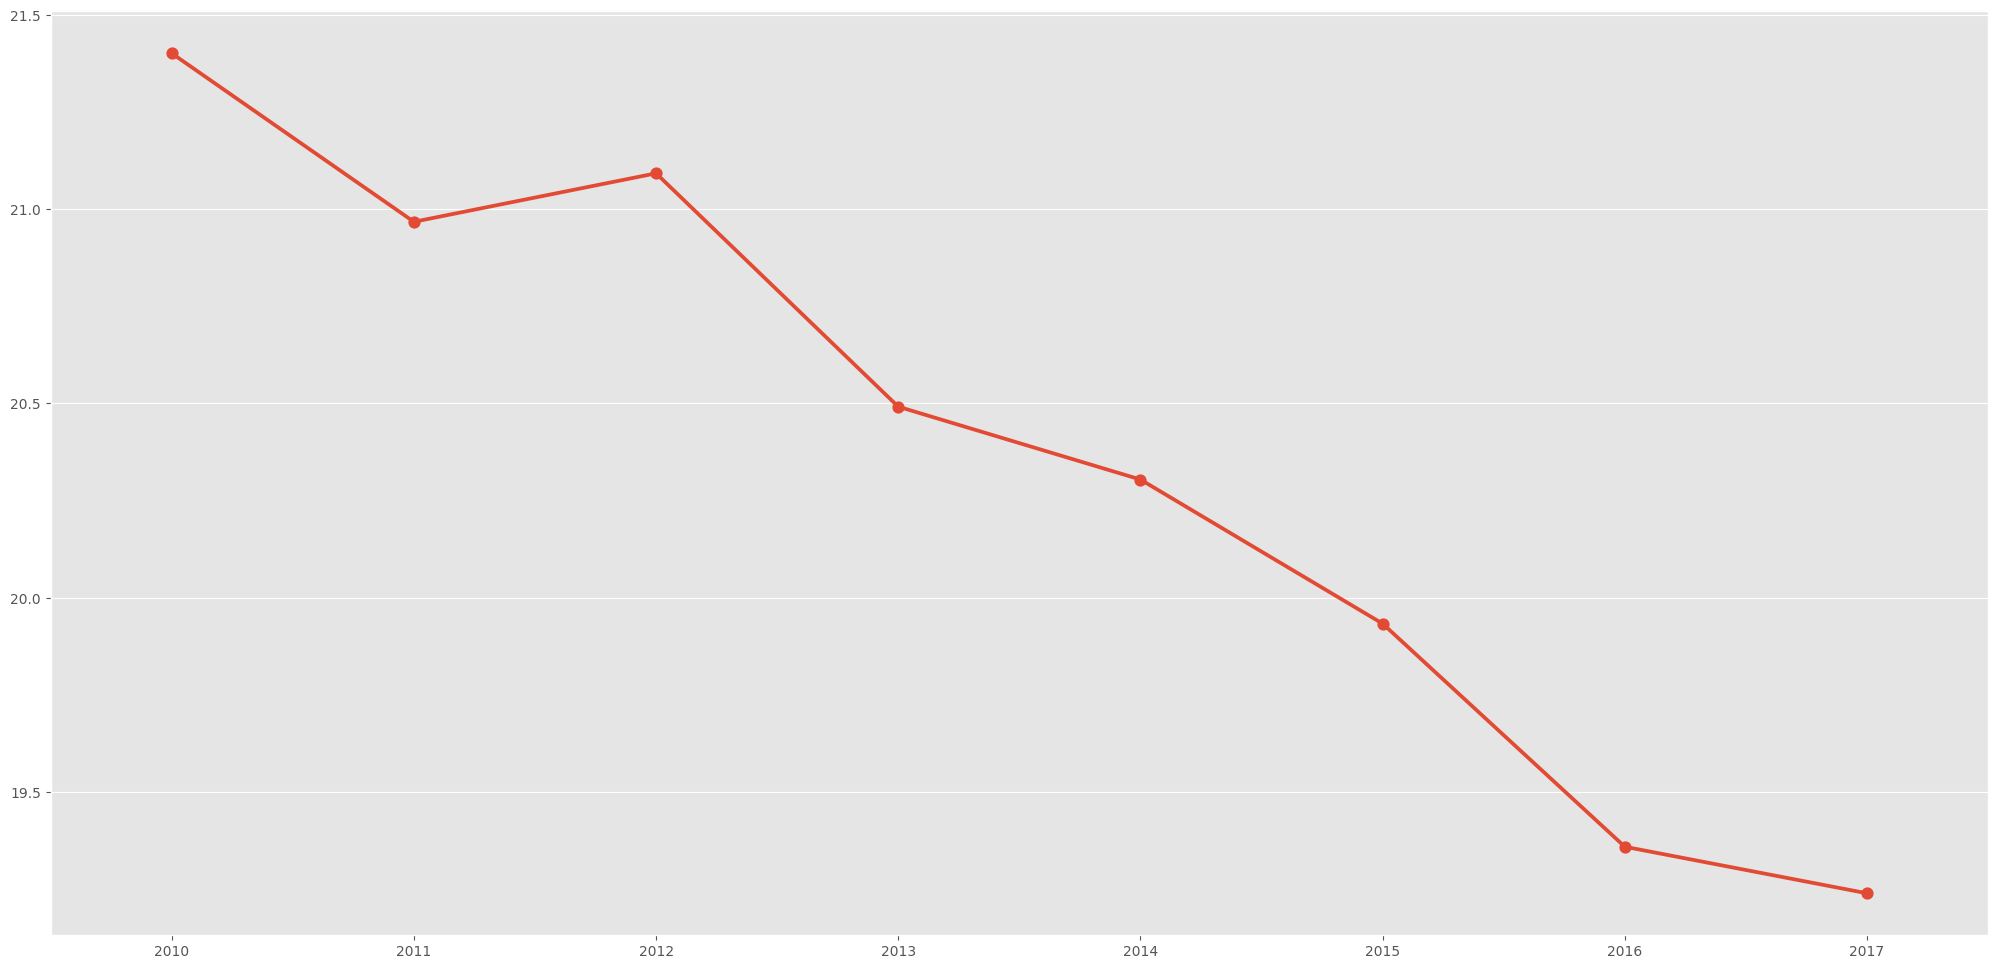

In [6]:
# Tomar el dataframe que aún contiene la columna "Country" y la especificamos como índice
chi_df_country_index = chi_df_country.set_index(chi_df_country["Country"])
chi_df_country_index.drop(chi_df_country_index.columns[[1]],axis=1, inplace = True)

# Convertir los datos de string a numericos
for col in chi_df_country_index.columns:
  chi_df_country_index[col] = pd.to_numeric(chi_df_country_index[col])

# Graficar la media del coeficiente de desigualdad humana anual
sb.pointplot(chi_df_country_index.mean()[1:], )

De la gráfica podemos observar que de forma general el coeficiente de desigualdad humana ha disminuido con el paso de los años y tuvo su caída más significativa entre el 2012 y 2013.

In [7]:
# Media del coeficiente de desigualdad humana de cada país
chi_df_country_index['Inequality mean'] = chi_df_country_index.iloc[:,1:].mean(axis=1).sort_values()
chi_df_country_index.iloc[:,1:].mean(axis=1).sort_values()

,0
Country,
Czechia,5.3625
Slovenia,5.7625
Iceland,5.9250
Finland,6.1750
Norway,6.2125
...,...
Nigeria,38.4000
Sierra Leone,38.9625
Haiti,39.1500


In [8]:
desigualdad_baja = ["Czechia", "Slovenia", "Iceland", "Finland", "Norway"]
desigualdad_alta = ["Nigeria", "Sierra Leone", "Haiti", "Guinea-Bissau", "Central African Republic"]
chi_df_country_index.iloc[:,1:].mean(axis=1).loc[["Czechia", "Slovenia", "Iceland", "Finland", "Norway"]]

,0
Country,
Czechia,5.3625
Slovenia,5.7625
Iceland,5.9250
Finland,6.1750
Norway,6.2125


<Axes: ylabel='HDI Rank (2017)'>

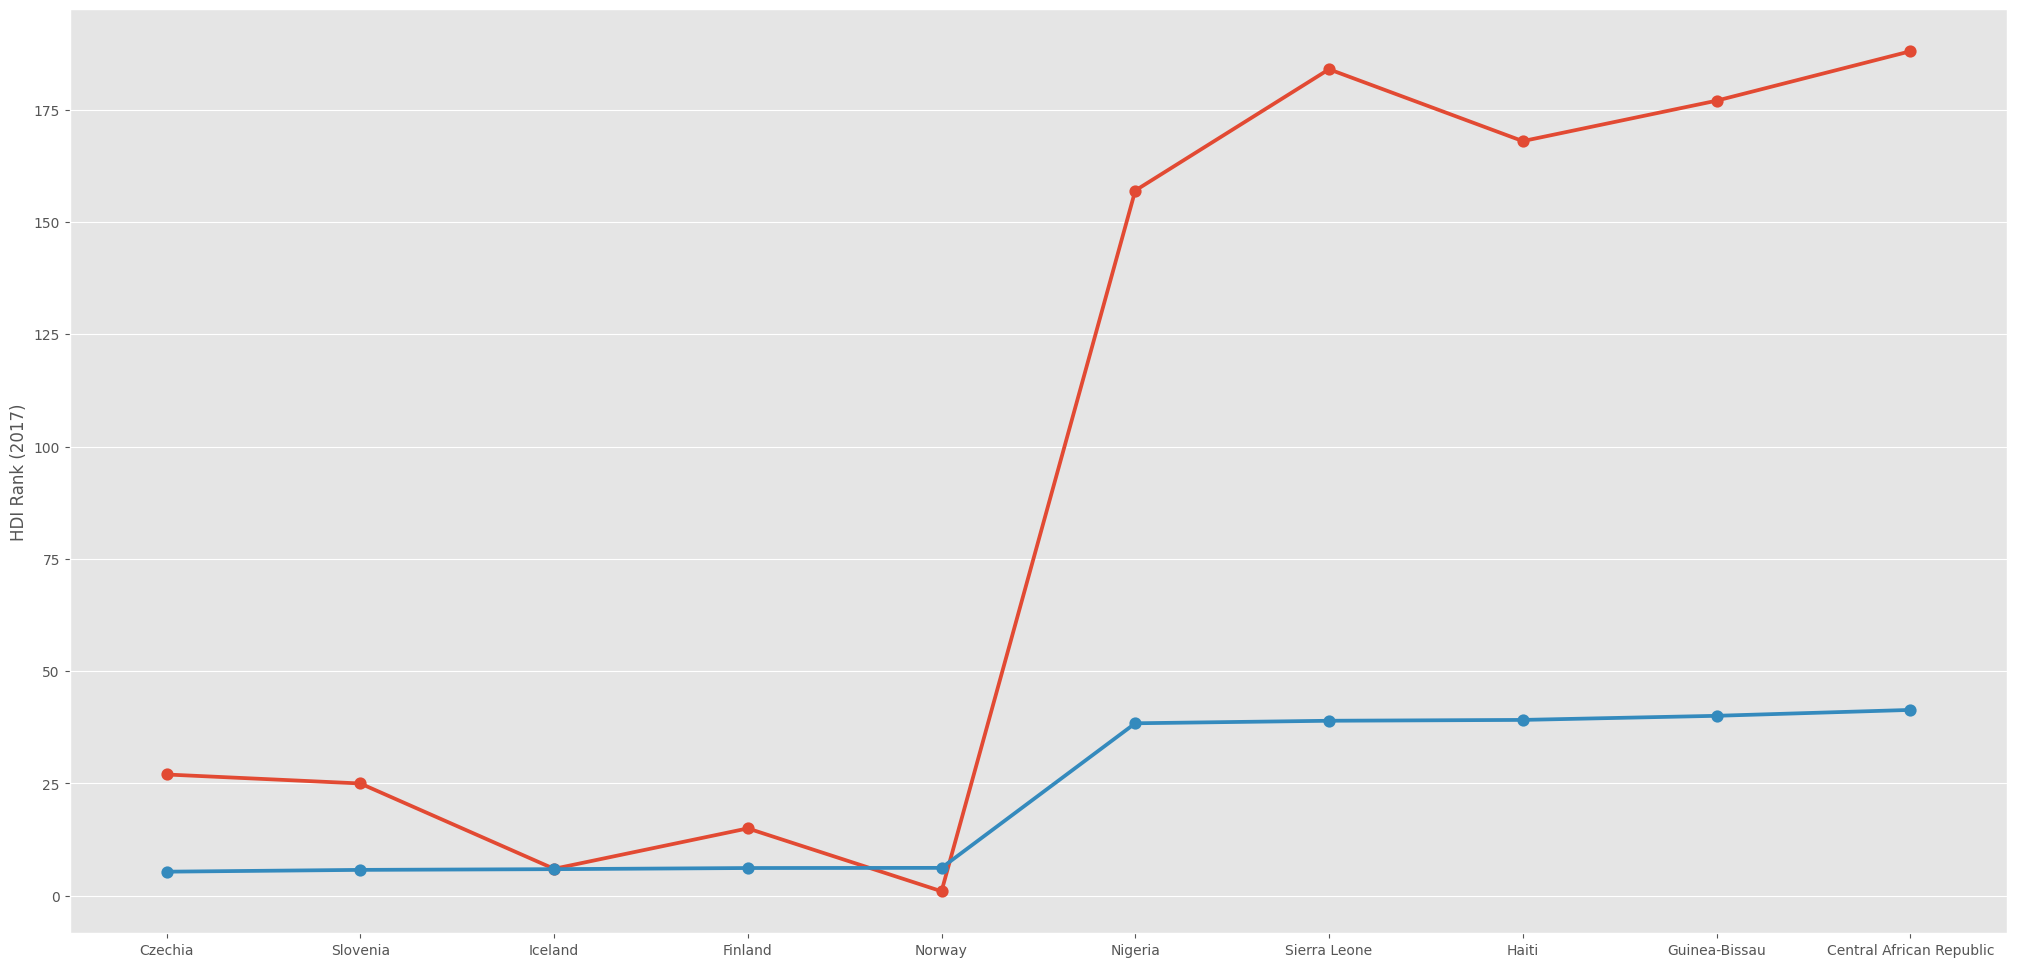

In [9]:
# Comparación entre indice de desarrollo humano y coeficiente de desigualdad humana para los paises con mayor y menor desigualdad

sb.pointplot(data=chi_df_country_index.loc[["Czechia", "Slovenia", "Iceland", "Finland", "Norway", "Nigeria", "Sierra Leone", "Haiti", "Guinea-Bissau", "Central African Republic"]],
            x=["Czechia", "Slovenia", "Iceland", "Finland", "Norway", "Nigeria", "Sierra Leone", "Haiti", "Guinea-Bissau", "Central African Republic"],
           y="HDI Rank (2017)"
           )
sb.pointplot(data=chi_df_country_index.loc[["Czechia", "Slovenia", "Iceland", "Finland", "Norway", "Nigeria", "Sierra Leone", "Haiti", "Guinea-Bissau", "Central African Republic"]],
            x=["Czechia", "Slovenia", "Iceland", "Finland", "Norway", "Nigeria", "Sierra Leone", "Haiti", "Guinea-Bissau", "Central African Republic"],
           y="Inequality mean"
           )

Se observa que la relación entre estos dos indicadores es inversamente proporcional a excepción de Islandia y Noruega, es decir, en general podemos decir que a mayor índice de desarrollo humano menor coeficiente de desigualdad humano, hay que tener en cuenta que la gráfica en el caso del índice de desarrollo humano representa un ranking, es decir, a menor posición en el ranking mayor índice de desarrollo humano.

<Axes: ylabel='HDI Rank (2017)'>

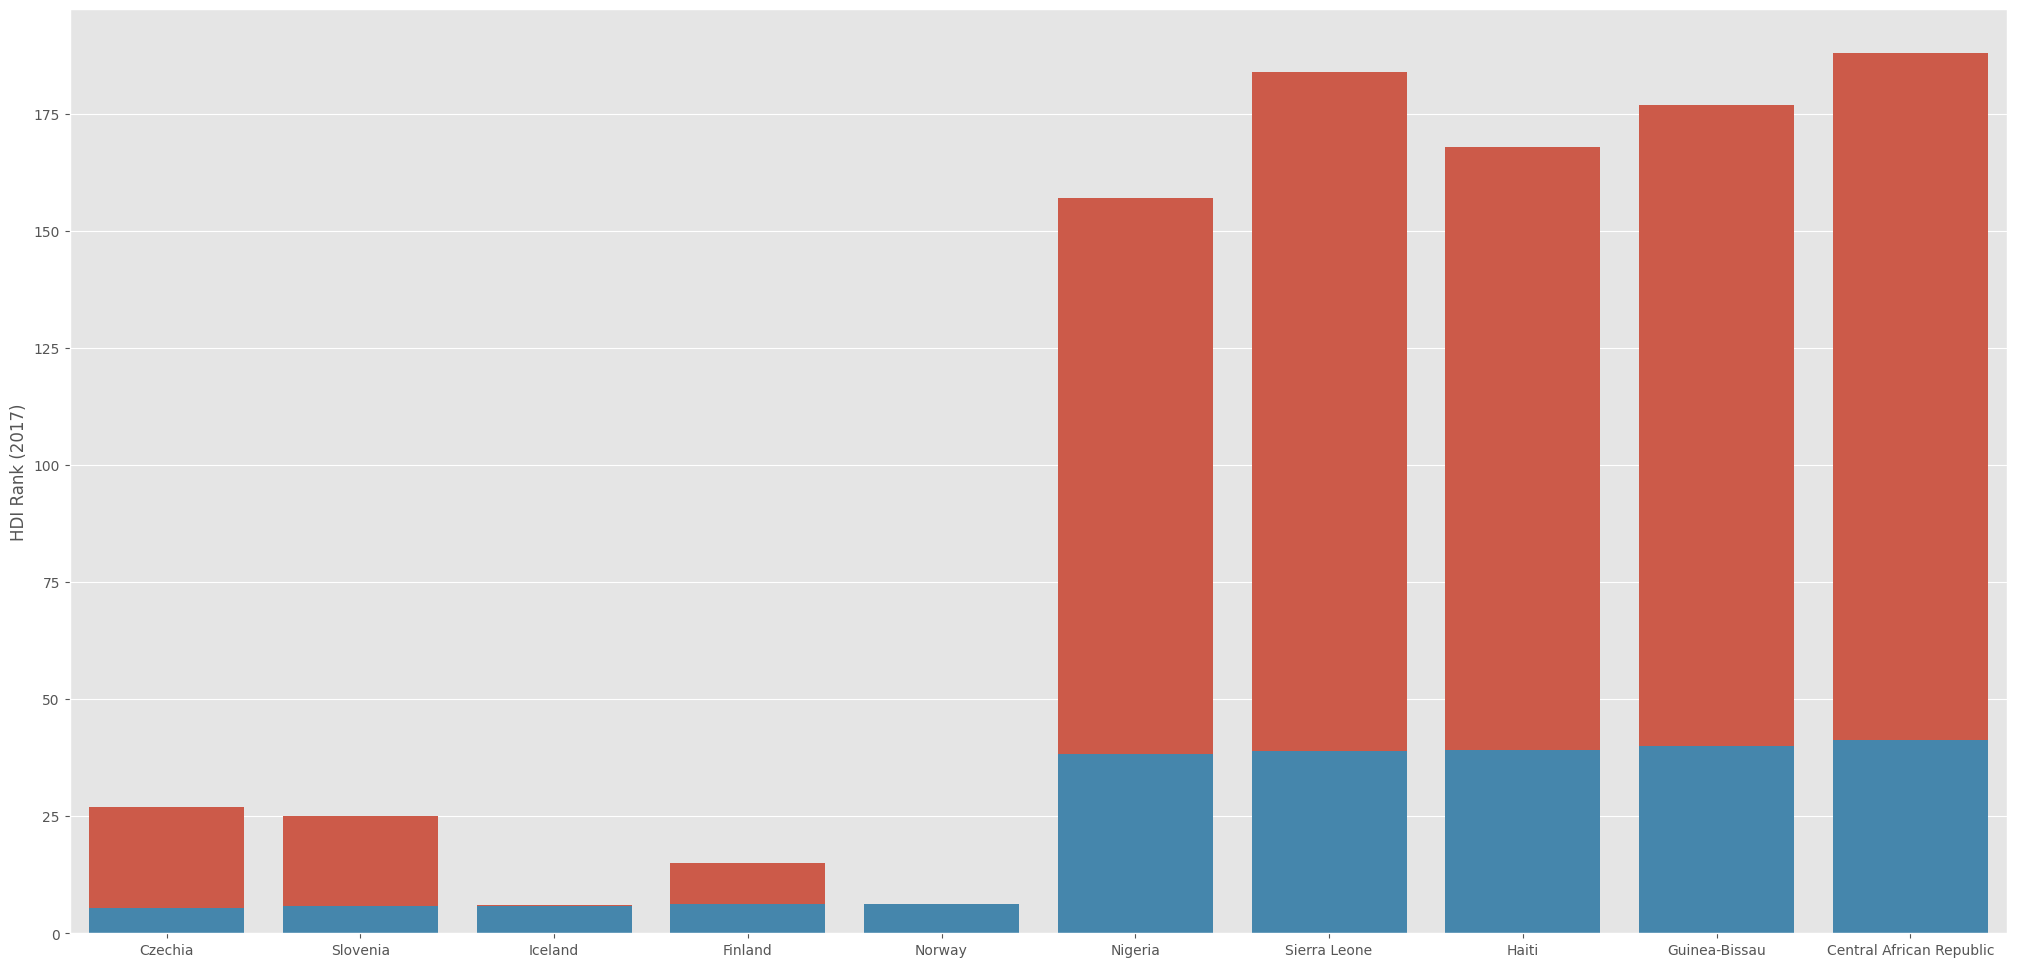

In [10]:
# Misma comparación que la anterior pero usando un gráfico de barras

sb.barplot(data=chi_df_country_index.loc[["Czechia", "Slovenia", "Iceland", "Finland", "Norway", "Nigeria", "Sierra Leone", "Haiti", "Guinea-Bissau", "Central African Republic"]],
            x=["Czechia", "Slovenia", "Iceland", "Finland", "Norway", "Nigeria", "Sierra Leone", "Haiti", "Guinea-Bissau", "Central African Republic"],
           y="HDI Rank (2017)"
           )
sb.barplot(data=chi_df_country_index.loc[["Czechia", "Slovenia", "Iceland", "Finland", "Norway", "Nigeria", "Sierra Leone", "Haiti", "Guinea-Bissau", "Central African Republic"]],
            x=["Czechia", "Slovenia", "Iceland", "Finland", "Norway", "Nigeria", "Sierra Leone", "Haiti", "Guinea-Bissau", "Central African Republic"],
           y="Inequality mean"
           )

In [11]:
# Cambio en el coeficiente de desigualdad humana de cada uno de los paises

(chi_df_country_index["2010"]-chi_df_country_index["2017"]).sort_values()

,0
Country,
Maldives,-6.5
Spain,-5.4
Ghana,-4.6
Serbia,-3.8
Greece,-3.2
...,...
Congo,8.7
Cambodia,9.4
Peru,10.9


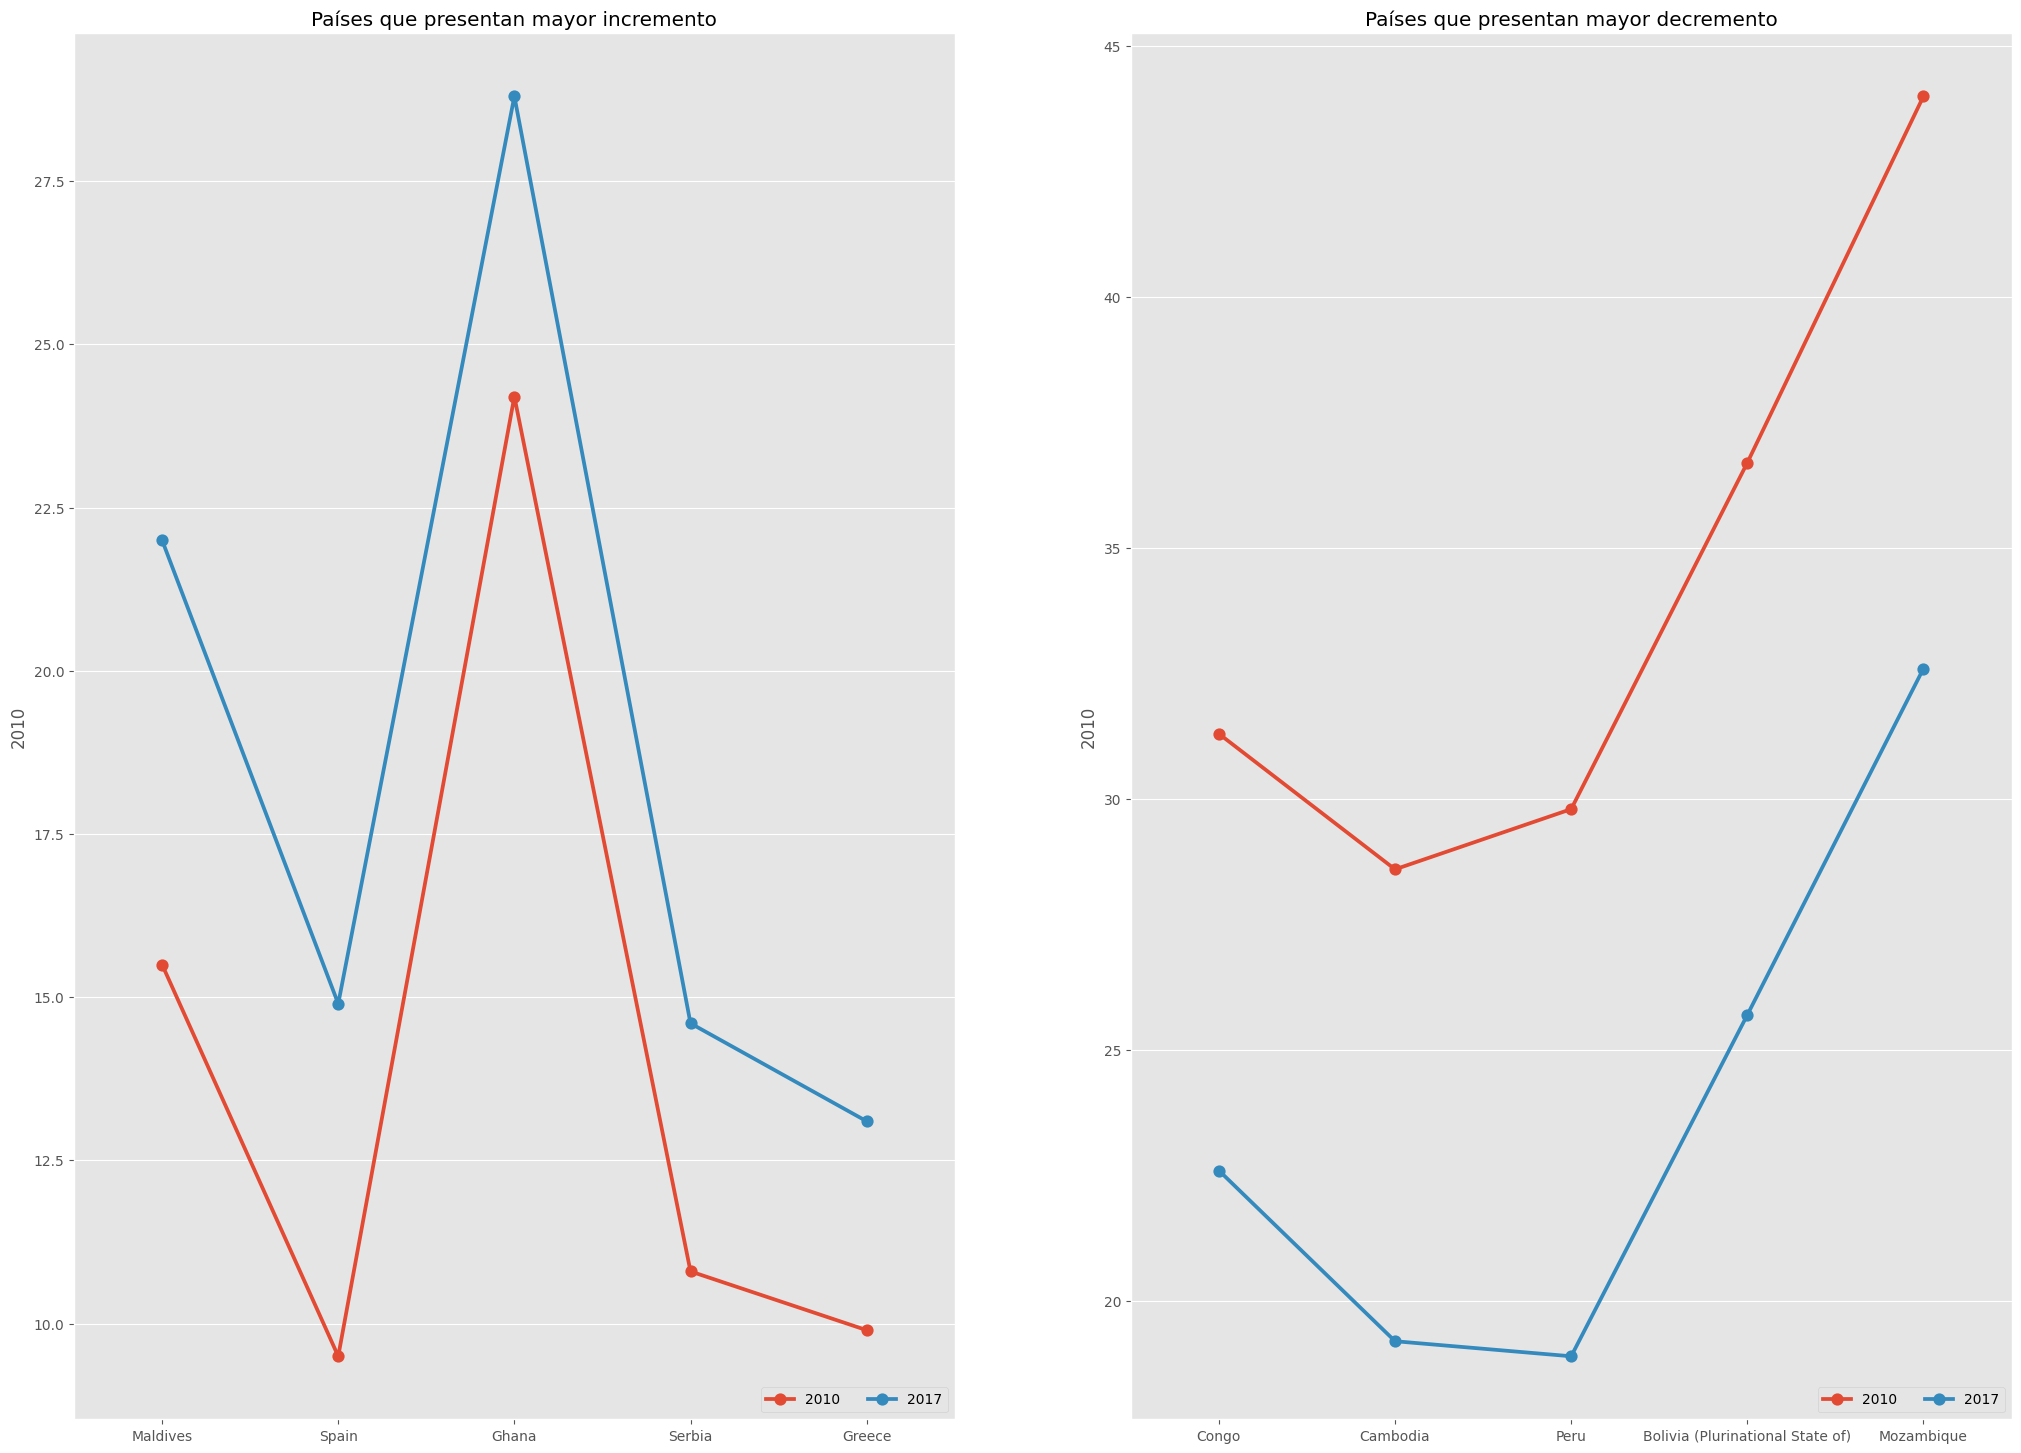

In [12]:
# Gráficas para observar los paises con mayor incremento y decremento en el CHI entre 2010 y 2017

incremento = ["Maldives", "Spain", "Ghana", "Serbia", "Greece"]
decremento = ["Congo", "Cambodia", "Peru", "Bolivia (Plurinational State of)", "Mozambique"]
labels = ["Países que presentan mayor incremento", "Países que presentan mayor decremento"]
to_plot = [incremento, decremento]
f, ax = plt.subplots(1,2, figsize = (25,18))
ax = ax.flatten()


for i in range(2):
    sb.pointplot(data=chi_df_country_index.loc[to_plot[i]],
        x=to_plot[i], ax=ax[i],
                       y="2010", label = "2010"
        )
    sb.pointplot(data=chi_df_country_index.loc[to_plot[i]],
        x=to_plot[i], ax=ax[i],
        y="2017",label = '2017')
    ax[i].legend(ncol = 2, loc = 'lower right')
    ax[i].set_title(labels[i])

Es interesante observar que en los extremos de esta muestra la forma de las gráficas no cambia significativamente, simplemente se desplaza hacia arriba o hacia abajo respectivamente, se podría decir que tanto en los paises con mayor incremento como en los que tienen mayor decremento este se presenta de forma lineal
Tenemos un comportamiento directamente proporcional entre el año y el CHI para los paises con mayor incremento y tenemos un comportamiento inversamente proporcional entre el año y el CHI para los paises con mayor decremento.

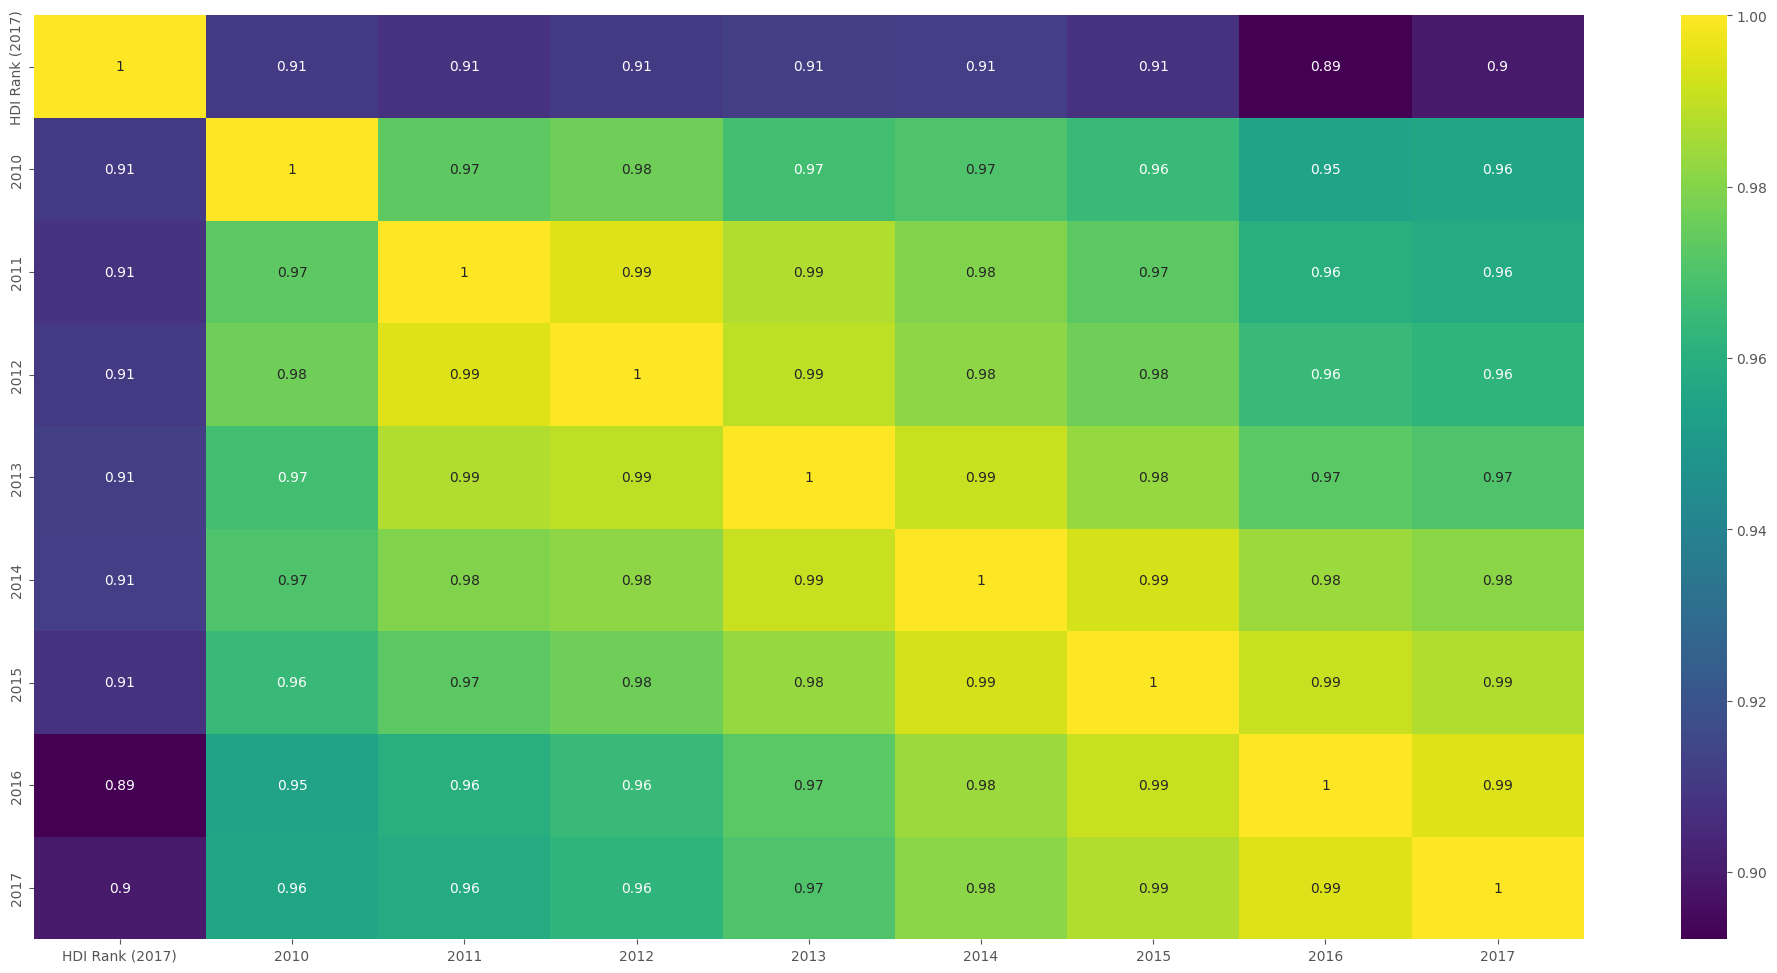

In [13]:
# Matriz de correlación
corrMatrix = chi_df.dropna().corr()
sb.heatmap(corrMatrix, annot=True, cmap='viridis')
plt.show()

De la matriz de correlacion se puede apreciar que todas las features tienen una correlación muy alta y de valor positivo, incluso llegando a un mínimo de 0.89 por lo que se pude predecir que se tendran buenos resultados al usar modelos de clustering.

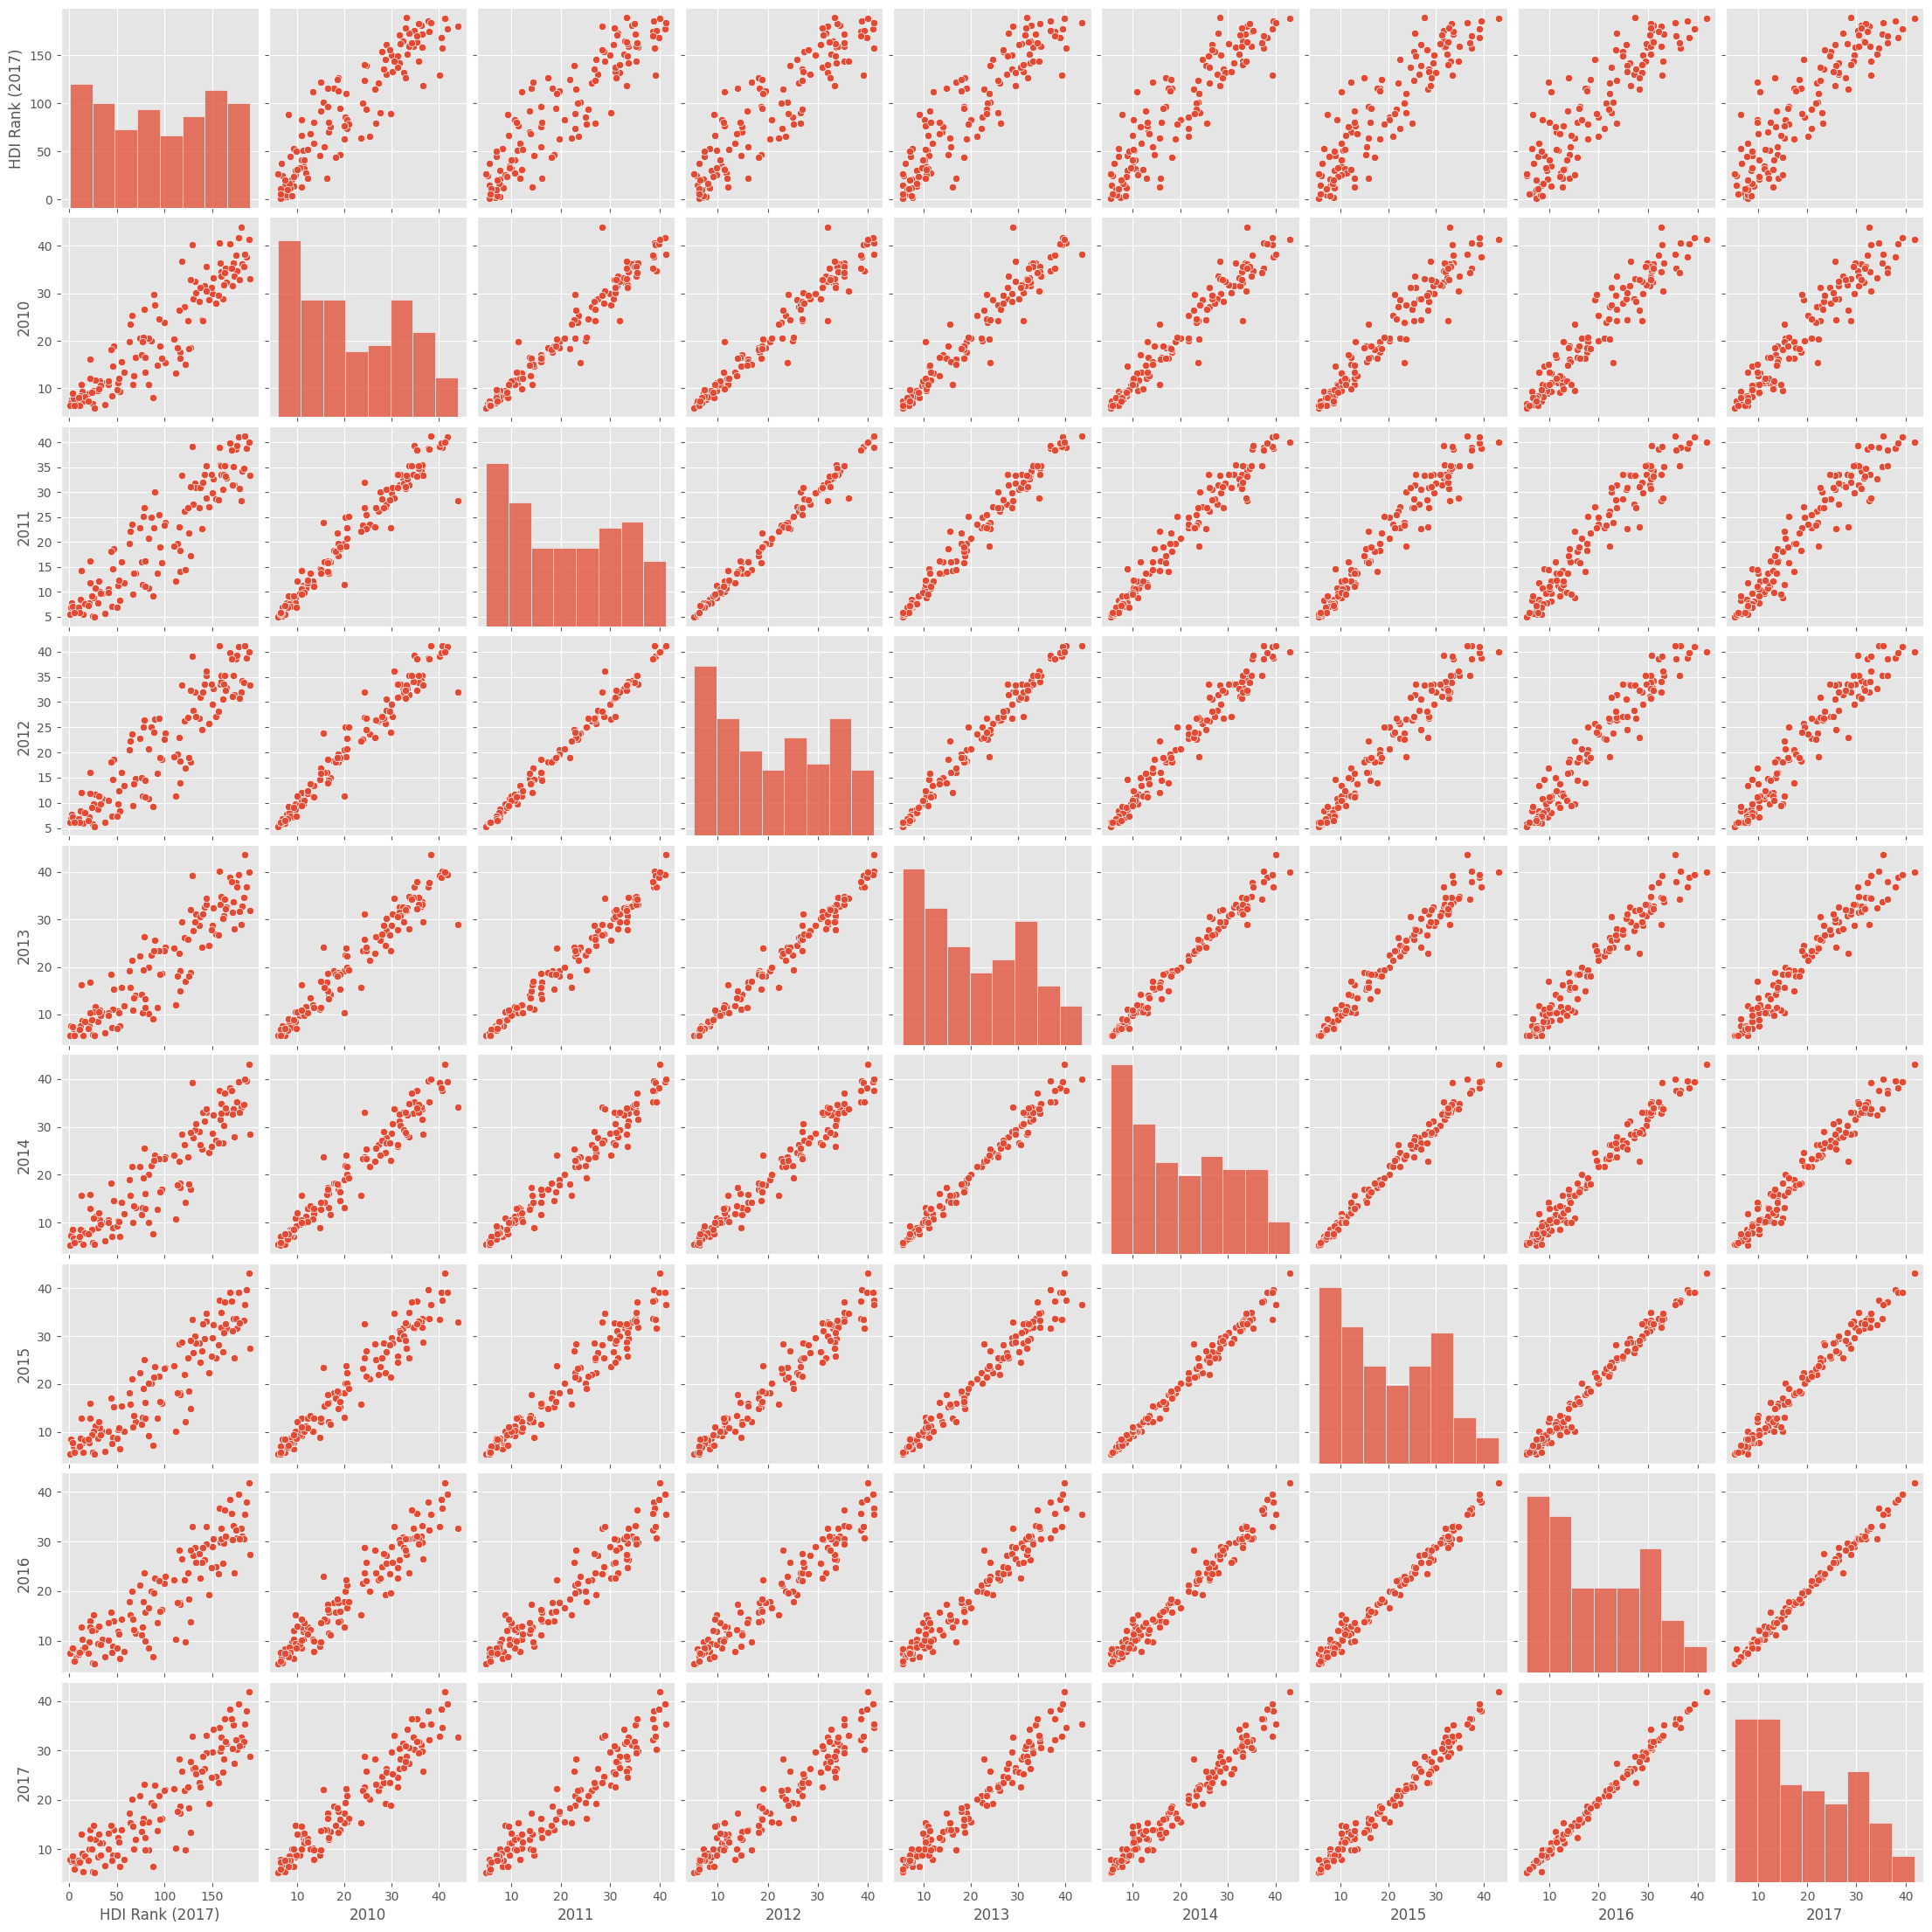

In [14]:
# Gráfico pairplot
sb.pairplot(chi_df.dropna())

En el gráfico de pairplot podemos ver que las features entre si tienen todas una correlación muy alta y lineal.

In [15]:
# Dado que todas las caracteristicas tienen buena correlacion entre si, escogemos 3 que contrasten entre ellas
chi_df_3D = np.array(chi_df[['HDI Rank (2017)', '2010', '2017']])

chi_df_3D.shape

(121, 3)

La razón por la que se eligieron estas columnas son:

* **'HDI Rank (2017)'** es la unica que no hace parte de la serie de tiempo que se tiene en el dataset.

* **'2010' y '2017'** son los extremos de ese rango de tiempo.

In [16]:
import plotly.express as px
import plotly.graph_objects as go

# Visualizar datos graficamente
fig = px.scatter_3d(chi_df, x='HDI Rank (2017)', y="2017", z="2010", size='2010')
fig.show()

En el gráfico de dispersión se evidencia un fuerte comportamiento lineal al escoger estas 3 características

## 2. Técnicas para establecer el número de clústers

* Método 1: Curva de codo

In [17]:
# se define la cantidad de clusters con los que se quiere probar
maxClusters = 10

In [18]:
# Curva de codo

def elbow_curve(data, maxClusters = 15):

  # rango de valores del parámetro a optimizar (cantidad de clusters)
  maxClusters = range(1, maxClusters + 1)
  inertias = []

  # se ejecuta el modelo para el rango de clusters y se guarda la inercia
  # respectiva obtenida para cada valor
  for k in maxClusters:
    kmeanModel = KMeans(n_clusters = k)
    kmeanModel.fit(data)
    inertias.append(kmeanModel.inertia_)

  # Grafico de los resultados obtenidos para cada valor del rango
  print("Valores: ",inertias)
  plt.figure(figsize=(10, 8))
  plt.plot(maxClusters, inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

Valores:  [430096.1639669423, 98561.73165570182, 44333.82381996289, 26290.764339817277, 18325.300460069964, 13841.65013623188, 11600.363003264847, 9457.04610155196, 7697.38470409982, 6881.444850982353]


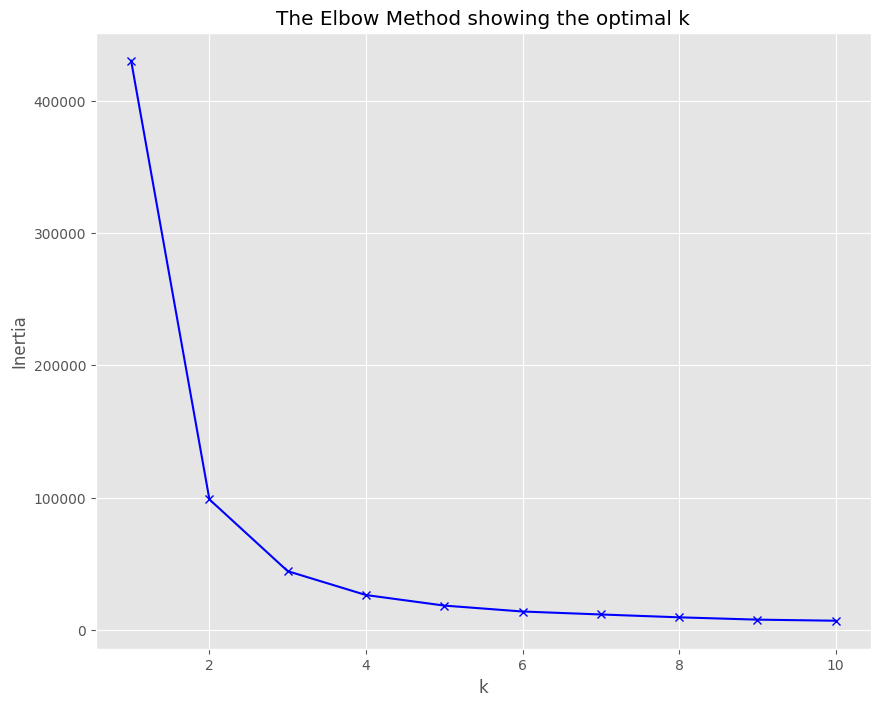

In [19]:
elbow_curve(chi_df_3D, maxClusters = maxClusters)

En la gráfica de codo podemos apreciar como óptimo(codo) **k=3** aunque **k=4** también podría ser una buena opción ya que al ser una gráfica puede tener cesgos al graficar el codo en valores más pequeños como **k=4**

* Método 2: Estadístico de gap

In [20]:
# Estadístico de gap

# nrefs es la cantidad de datos ("datasets") de referencia contra los que se va a comparar
def optimalK(data, nrefs=3, maxClusters=15):

    gaps = np.zeros((len(range(1, maxClusters+1)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters+1)):

        # guardara los resultados de dispersión de cada distribución simulada
        refDisps = np.zeros(nrefs)

        # Genera las muestras aleatorias indicadas con nrefs y ejecuta k-means
        # en cada bucle obteniendo los resultados de dispersión (inercia)
        # para cada conjunto generado.
        for i in range(nrefs):

            # Crea nuevo conjunto aleatorio de referencia
            # Se puede usar una semilla para tener reproducibilidad
            np.random.seed(0)
            randomReference = np.random.random_sample(size=data.shape)

            # se ajusta el modelo al conjunto de referencia
            km = KMeans(k)
            km.fit(randomReference)
            # se guarda la dispersión obtenida
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Se ajusta el modelo a los datos originales y se guarda su inercia
        km = KMeans(k)
        km.fit(data)

        origDisp = km.inertia_

        # Calcula el estadístico de gap para k clusters usando el promedio de
        # las dispersiones de los datos simulados y la dispersión de los datos originales.
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Guarda el estadístico de gap obtenido en este bucle.
        gaps[gap_index] = gap

        resultsdf = resultsdf._append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    # Selecciona el "primer máximo" de los estadísticos obtenidos y devuelve
    # su respectivo número de clusters
    for i in range(0, len(gaps)-1):
      if gaps[i+1] <= gaps[i]:
        return (i+1, resultsdf)
    return (len(gaps), resultsdf)


In [21]:
k, gapdf = optimalK(chi_df_3D, nrefs=5, maxClusters=maxClusters)
print('La cantidad óptima de clusters es: ', k)

La cantidad óptima de clusters es:  9


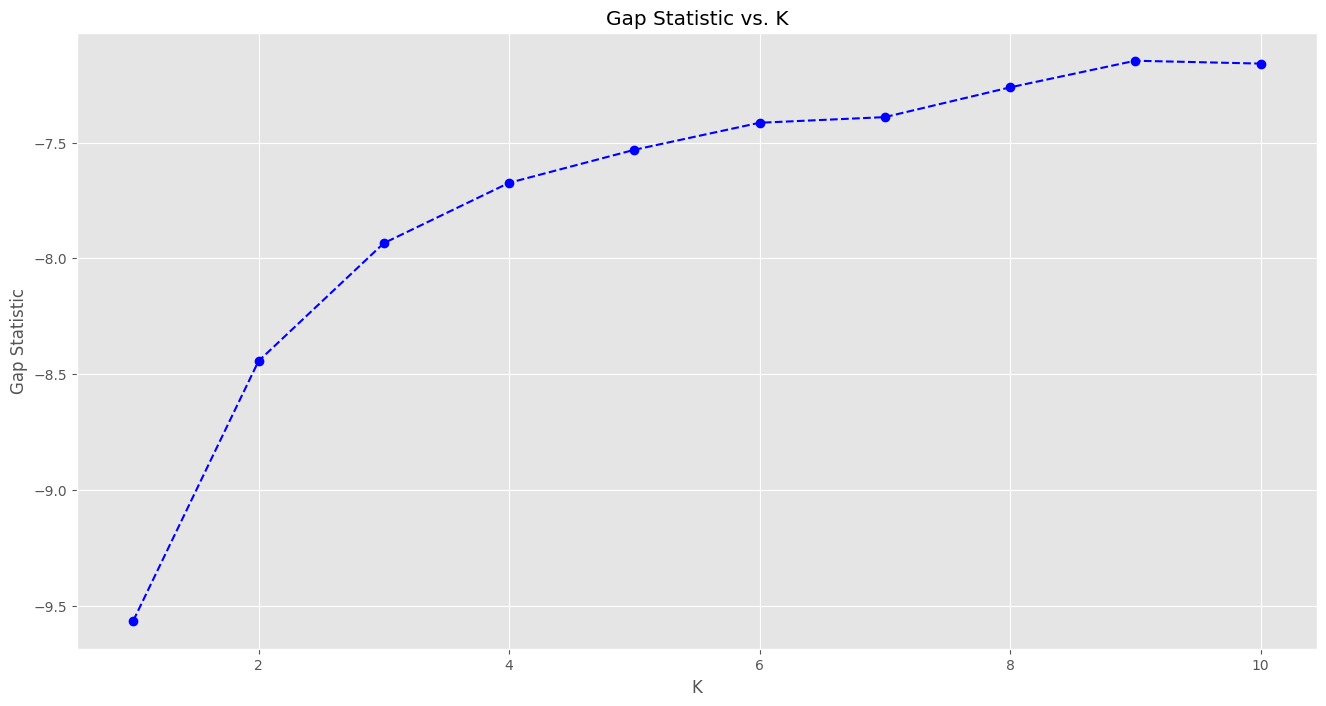

In [22]:
plt.figure(figsize=(16,8))
plt.plot(gapdf['clusterCount'], gapdf['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

Según el método de gap, el valor óptimo estaría en **k=9**, lo que supondría un sobreajuste al modelo, así que descartamos la posibilidad de tener un **k** tan alto para evitar el sobreajuste.

* Método 3: Análisis de silueta

For n_clusters = 2 The average silhouette_score is : 0.6370375083244227
For n_clusters = 3 The average silhouette_score is : 0.5868710867311592
For n_clusters = 4 The average silhouette_score is : 0.5529998330095544
For n_clusters = 5 The average silhouette_score is : 0.5170350366801502
For n_clusters = 6 The average silhouette_score is : 0.4829403364291901


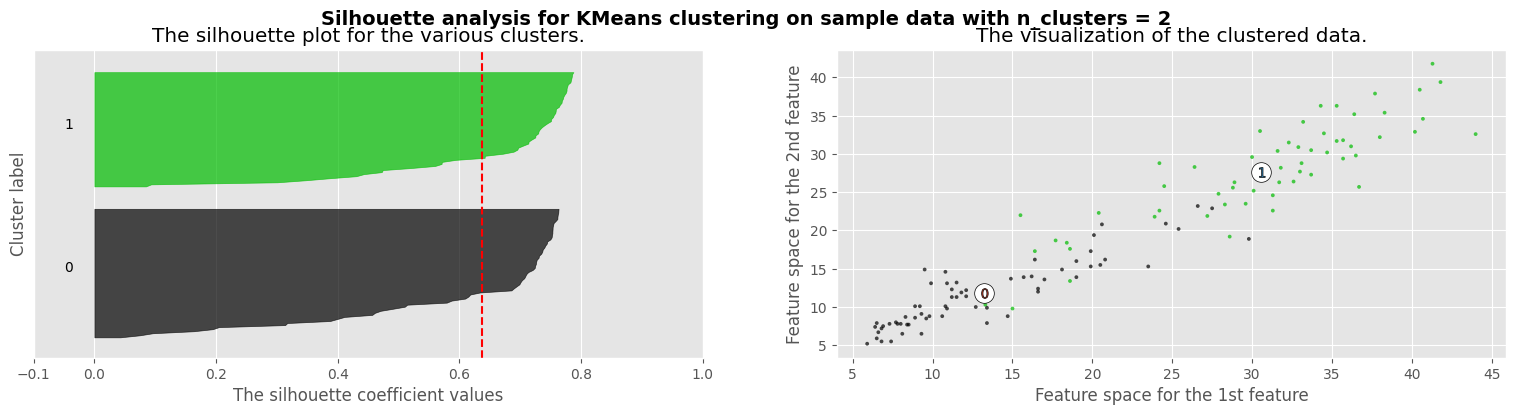

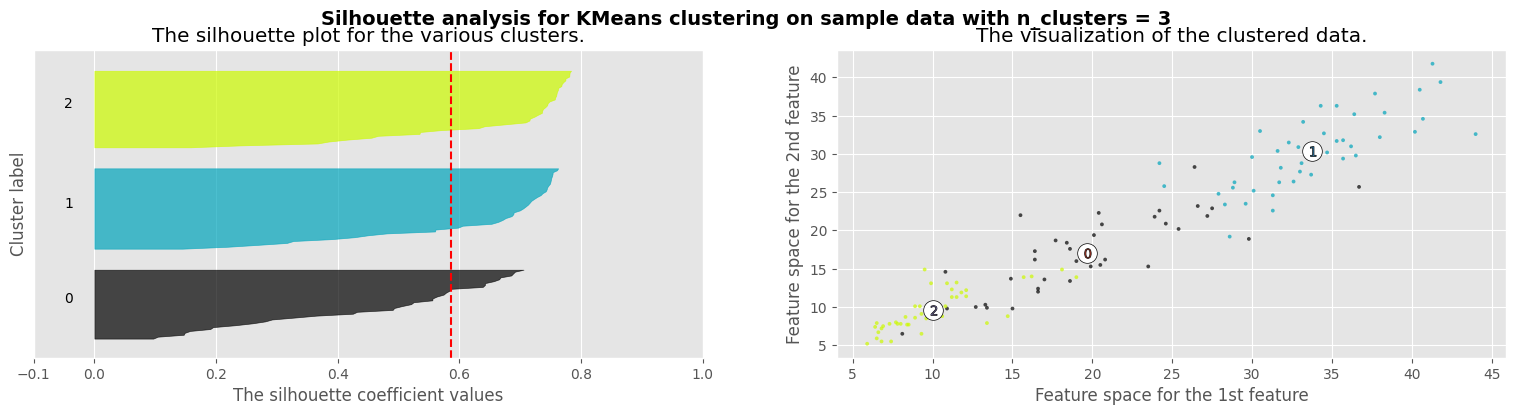

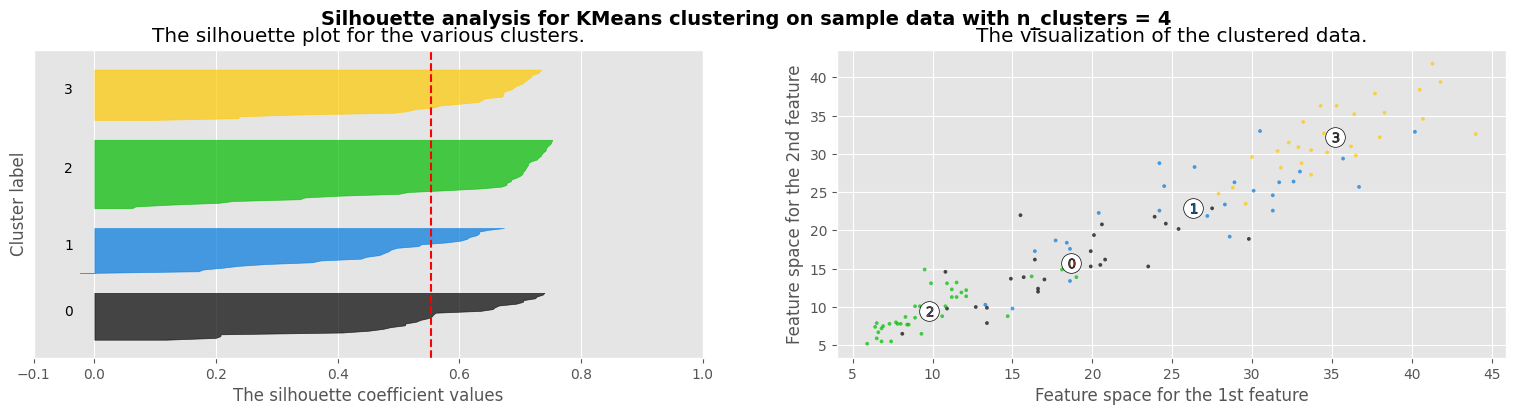

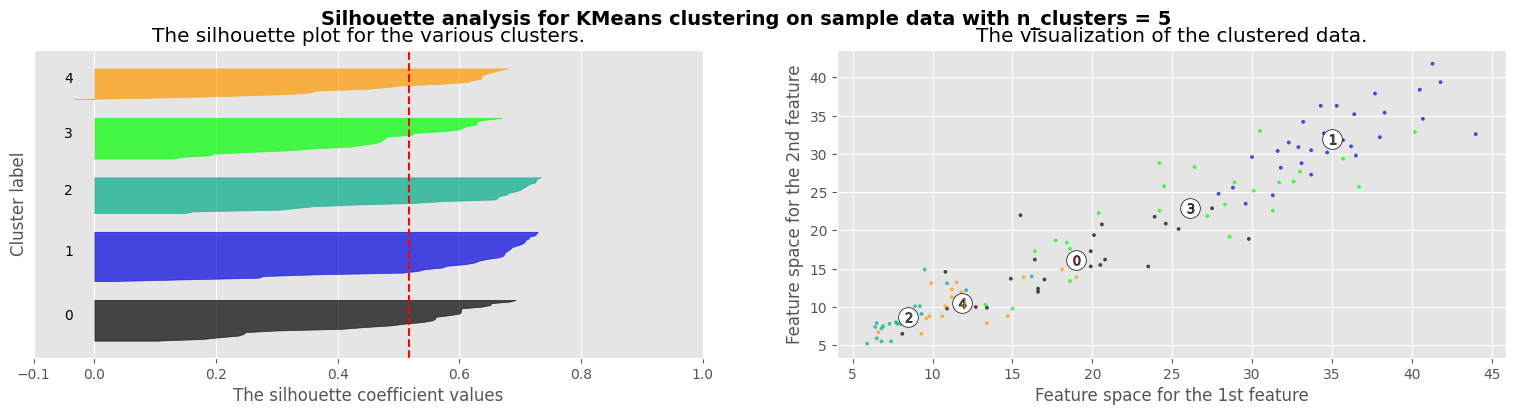

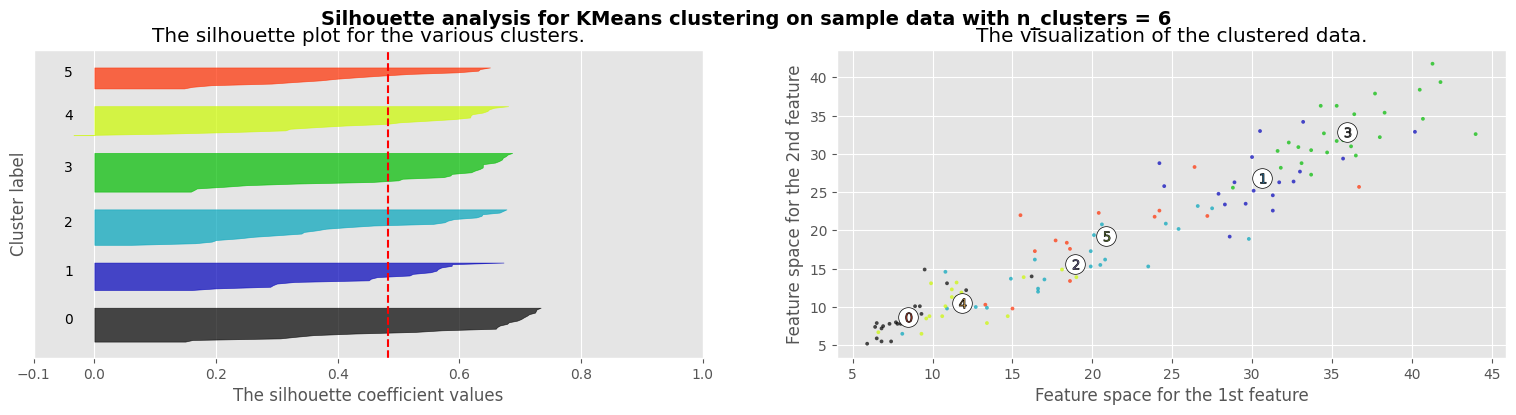

In [23]:
# Análisis de silueta

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

colors_k_means = ['cyan','purple','orange']
range_n_clusters = [2, 3, 4, 5, 6]
X = chi_df_3D

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(19, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all

    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = plt.cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 1], X[:, 2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 1], centers[:, 2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[1], c[2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

En el análisis de silueta se puede observar que **k=3** puede ser una buena elección, ya que no muestra valores negativos en alguno de sus cluster, como lo hacen **k=4** y **k=5**.

## 3. Dendograma

In [24]:
# Escalar los datos

# Importamos el esclador de sklearn
from sklearn.preprocessing import MinMaxScaler

# Inicializamos el escalador
scaler = MinMaxScaler()

# Con esta función ajustamos el escalador en base a los datos y luego los transforma
chi_df_3D_scaled = scaler.fit_transform(chi_df_3D)

# Visualizamos que los datos ya están escalados
chi_df_3D_scaled

array([[0.27659574, 0.08923885, 0.03551913],
       [0.79255319, 0.63254593, 0.66666667],
       [0.36702128, 0.2808399 , 0.18579235],
       [0.75      , 0.67716535, 0.57650273],
       [0.98404255, 0.83464567, 0.89344262],
       [0.32978723, 0.36745407, 0.33060109],
       [0.39893617, 0.29133858, 0.2295082 ],
       [0.7712766 , 0.59580052, 0.38251366],
       [0.45212766, 0.37270341, 0.38797814],
       [0.18085106, 0.13910761, 0.16666667],
       [0.90957447, 0.80052493, 0.81967213],
       [0.26595745, 0.13910761, 0.19398907],
       [0.61170213, 0.30971129, 0.36885246],
       [0.87234043, 0.69291339, 0.71857923],
       [0.03191489, 0.02362205, 0.05464481],
       [0.16489362, 0.14698163, 0.16666667],
       [0.63829787, 0.55905512, 0.45628415],
       [0.42021277, 0.2808399 , 0.19672131],
       [0.95744681, 0.79527559, 0.70491803],
       [0.14361702, 0.15485564, 0.18306011],
       [0.47340426, 0.56692913, 0.48360656],
       [0.30319149, 0.19685039, 0.07377049],
       [0.

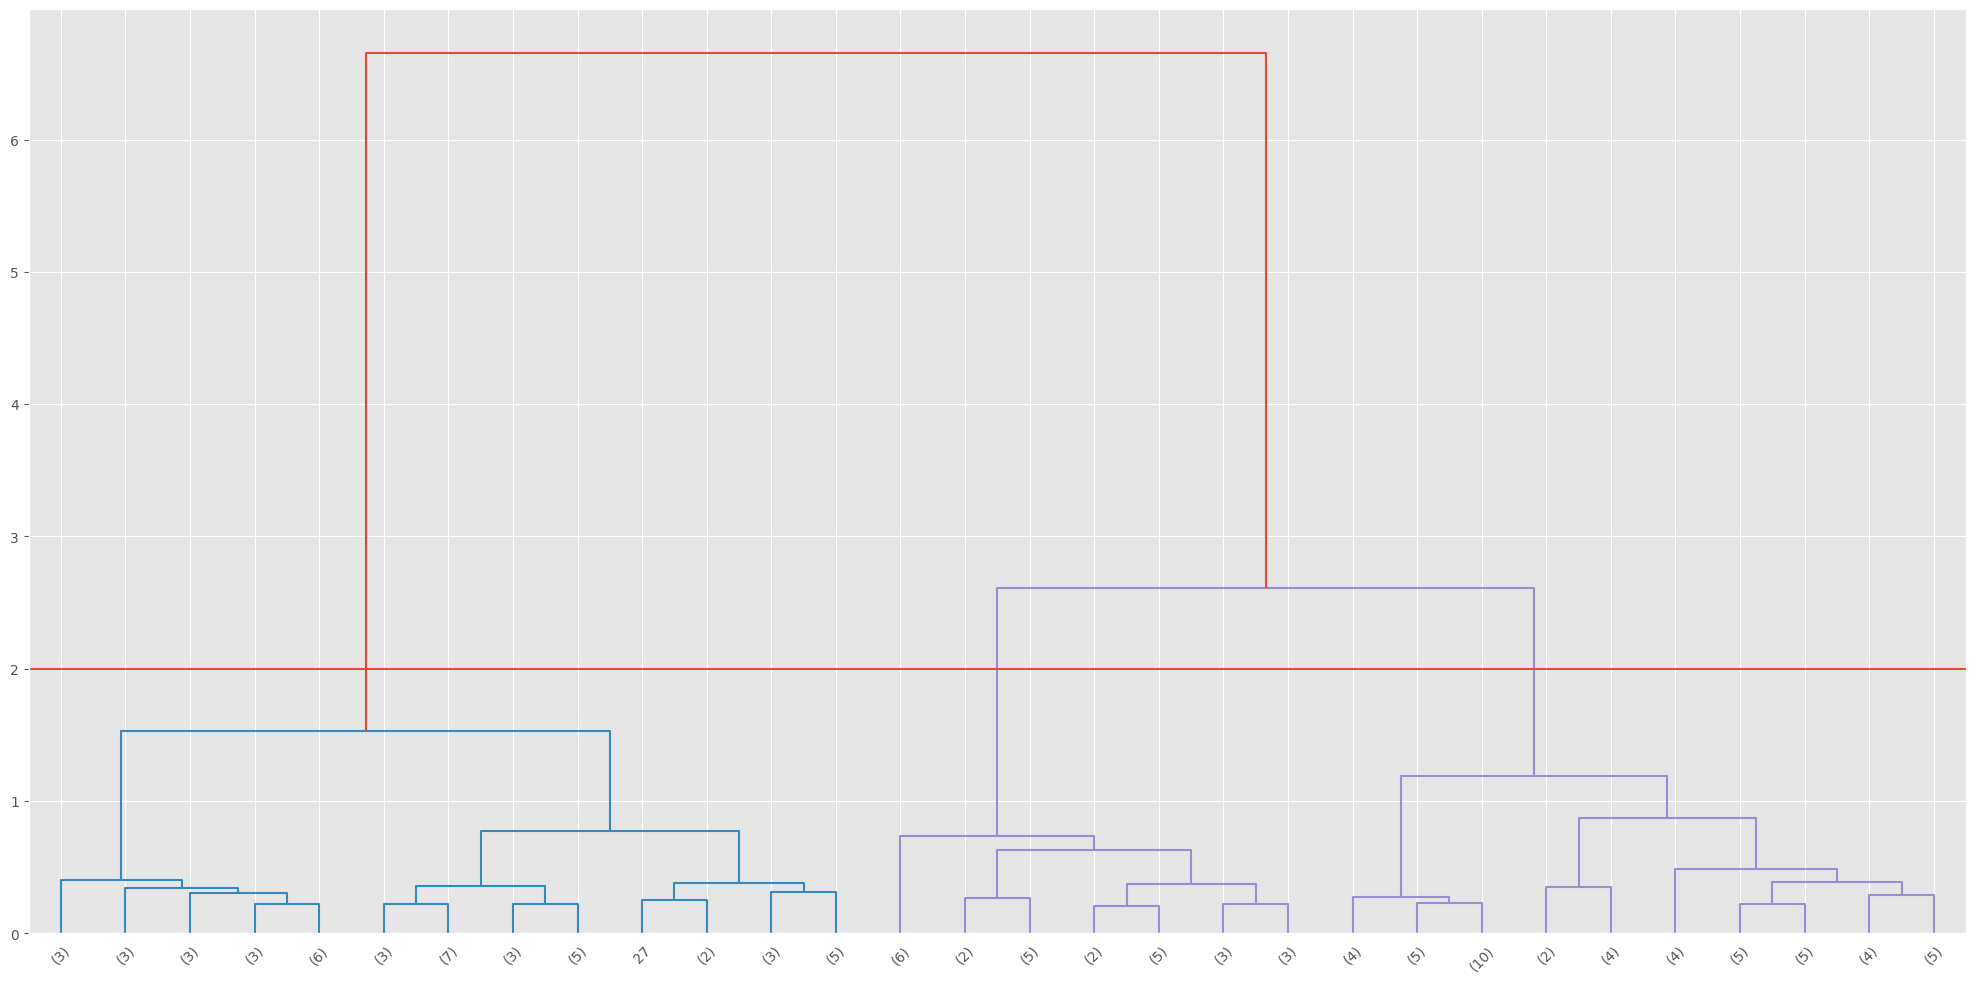

In [25]:
# Creacion del dendograma
dendogram = sch.dendrogram(sch.linkage(chi_df_3D_scaled, method="ward"), truncate_mode="lastp")

# Graficar una linea a una altura especifica en el dendograma
plt.axhline(y=2)

En el dendograma podemos observar que el valor óptimo sería **k=3**. En base a lo observado en los estadísticos anteriores en los cuales silueta, codo y dendograma sugieren como óptimo un valor de **k=3** construiremos el modelo en con este número de clusters.

## 4. Resultados usando k-means y clustering aglomerativo

* k-means

In [26]:
# Creamos el modelo de kmeans con el array que contiene los datos escalados
kmeans_model_3D = KMeans(n_clusters=3, max_iter=1000).fit(chi_df_3D_scaled)

# Extraemos la etiqueta del cluster asignado por el modelo a cada dato del array.
labels_3D = kmeans_model_3D.labels_

# Extraemos los centroides de cada cluster
centroids_3D = kmeans_model_3D.cluster_centers_

# KMeans no crea los labels y centroides de manera ordenada
# por eso los ordenaremos de manera ascendente
# Crear el orden de los centroides en base a su primera coordenada
order = np.argsort(centroids_3D[:, 0])
centroids_3D = centroids_3D[order]

# Ordenar los labels
ordered_labels = np.zeros_like(labels_3D)
for i, label in enumerate(order):
    # Asigna a cada elemento el label correcto en base al nuevo orden
    ordered_labels[labels_3D == label] = i

# Almacenar el nuevo orden
labels_3D = ordered_labels

In [27]:
# Centroides ordenados
print(centroids_3D)

[[0.15640831 0.09555056 0.11241218]
 [0.47434293 0.36629612 0.32280617]
 [0.83049645 0.72808399 0.68257438]]


Gráfica de los clústers y sus centroides para comprender y analizar los resultados obtenidos al usar el modelo k-means

In [28]:
# Anteriormente se estaba trabajando con un numpy.array para agilizar
# los cálculos, ahora crearemos dataframes para facilitar
# la realización de los gráficos y también se utilizarán los datos originales
# sin escalar, para mejorar la interpretación.

# Apartir del df original se crea el df solo con las columnas de interés
pd_df = chi_df[['HDI Rank (2017)', '2010', '2017']]

# Se añade una columna con la etiqueta del cluster al que depende cada dato
# Para utilizarlo al graficar
pd_df["cluster"] = labels_3D
pd_df.head()

,HDI Rank (2017),2010,2017,cluster
0,53,9.3,6.5,0
1,150,30.0,29.6,2
2,70,16.6,12.0,1
3,142,31.7,26.3,2
4,186,37.7,37.9,2


In [29]:
# Para poder visualizar bien los centroides debemos llevarlos a la escala original
centroids_scaled = scaler.inverse_transform(centroids_3D)

# Creamos un pd.DataFrame con los centroides escalados con el fin de graficarlos
pd_centroids_scaled =  pd.DataFrame(centroids_scaled, columns= ["HDI Rank (2017)", "2010", "2017"])
pd_centroids_scaled

,HDI Rank (2017),2010,2017
0,30.404762,9.540476,9.314286
1,90.176471,19.855882,17.014706
2,157.133333,33.640000,30.182222


In [30]:
# Se crea el gráfico 3D para el modelo K-means
fig = px.scatter_3d(pd_df, x="HDI Rank (2017)", y="2010", z="2017", color="cluster")

# Creamos el gráfico de los centroides
pd_centroids = pd.DataFrame(centroids_3D, columns= ["HDI Rank (2017)", "2010", "2017"])
scatter = go.Scatter3d(x=pd_centroids_scaled["HDI Rank (2017)"], y=pd_centroids_scaled["2010"], z=pd_centroids_scaled["2017"],
    mode='text', text=['★']*len(pd_centroids_scaled), textposition='middle center', textfont=dict(size=40, color=colors_k_means), name="")

# Añadimos el gráfico de los centroides a el gráfico original
fig.add_trace(scatter)
fig.show()

En el gráfico se aprecia que el modelo se desempeña muy bien, también que todos los datos poseen un comportamiento lineal creciente y que los cluster segmentan los datos principalmente de acuerdo a ese comportamiento, es por esto que se aprecia que el cluster azul(etiqueta 0) esta compuesto por los datos que poseen en general los valores más bajos en las 3 características escogidas mientras que en el cluster rosa(etiqueta 2) se presenta lo opuesto, los datos que poseen en general los valores más altos en las 3 características escogidas. Y por ultimo tenemos el cluster amarrillo(etiqueta 1) que contiene los datos en el medio de el rango de las 3 características.

Se puede concluir que el modelo sería una buena herramienta para segmentar/estratificar países según su coeficiente de desigualdad como se muestra a continuación.

In [31]:
# Añadir columna
chi_df_country["Stratum"] = labels_3D

chi_df_country[["Country", "Stratum"]].head(20).sort_values(by="Stratum")

,Country,Stratum
0,Belarus,0
15,Cyprus,0
14,Sweden,0
11,Bulgaria,0
9,Lithuania,0
19,Italy,0
5,Costa Rica,1
6,Sri Lanka,1
8,Ecuador,1
12,Indonesia,1


* Clustering aglomerativo

In [32]:
# Creamos el modelo de clustering aglomerativo con el array que contiene los datos escalados
clustering_model_3D = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
clusters_ac = clustering_model_3D.fit_predict(chi_df_3D_scaled)

In [33]:
# Figura de los segmentación de los datos usando clustering aglomerativo

figure = px.scatter_3d(
    x=chi_df_3D_scaled[:, 0],
    y=chi_df_3D_scaled[:, 1],
    z=chi_df_3D_scaled[:, 2],
    color=clusters_ac,
    color_continuous_scale='Rainbow'
)

figure.show()

## 5. Tendencias

* La media del coeficiente de desigualdad humana ha disminuido entre el 2010 y el 2017. Tuvo su caída más significativa entre el 2012 y 2013.
* Los 5 paises con coeficiente de desigualdad humana más bajo entre el 2010 y el 2017 pertenecen al continente europeo mientras que los 5 con coeficiente de desigualdad humana más alto pertenecen al continente africano.
* Los países con el indice de desarrollo humano más alto presentan los coeficientes de desigualdad más bajos y viceversa.
* El país con el decremento más significativo en el coeficiente de desigualdad humana entre el 2010 y el 2017 es Mozambique y el país con el mayor incremento es Maldivas.
* El coeficiente de desigualdad humana es un indicador que puede presentar un incremento o decremento anual según el país analizado pero en ningun caso se observa un cambio de comportamiento brusco ya que depende de la desigualdad en los ingresos, educación y esperanza de vida de cada país y estos son factores que cambian lentamente.